# Toomre's stability criterion for a Kuzmin disc (3)

## Imports

In [1]:
import numpy as np
import scipy
import math
import random
import pandas as pd
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

rc_params = {'backend': 'ps',
            'font.family': 'Times New Roman',
            'font.sans-serif': ['Bitstream Vera Sans'],
            'axes.unicode_minus':False,
            'text.usetex':True,
            'axes.grid':True,
            'grid.linestyle':'-',
            'grid.linewidth':0.5,
            'hist.bins':50,
            'axes.labelsize':14,
            'axes.titlesize':14,
            'xtick.labelsize':10,
            'ytick.labelsize':10,
            'legend.fontsize':10,
            'savefig.bbox':'tight',
            'savefig.transparent':False,
            'figure.dpi':100}
plt.rcParams.update(rc_params)

In [2]:
def dati (data,N):

    step = N*4+3
    
    t = np.array([data.iloc[2::step,0].copy().dropna()]).flatten()
    m = np.array([data.iloc[i::step,0].copy().dropna() for i in range(3, N+3)])
    x = np.array([data.iloc[i::step,0].copy().dropna() for i in range(N+3, 2*N+3)])
    y = np.array([data.iloc[i::step,1].copy().dropna() for i in range(N+3, 2*N+3)])
    z = np.array([data.iloc[i::step,2].copy().dropna() for i in range(N+3, 2*N+3)])
    vx = np.array([data.iloc[i::step,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
    vy = np.array([data.iloc[i::step,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
    vz = np.array([data.iloc[i::step,2].copy().dropna() for i in range(2*N+3, 3*N+3)])
    phi = np.array([data.iloc[i::step,0].copy().dropna() for i in range(3*N+3, 4*N+3)])
        
    M = m[::,0]
    
    return x,y,z,vx,vy,vz,t,phi,M

def find_nearest(array, value):
    array = np.asarray(array)
    idx   = (np.abs(array-value)).argmin()
    return idx

In [3]:
def shrinking_sphere (x, y, M, N, last_counts, min_particles = None, rlim=None):
    
    cm_x = np.inner(x,M)/np.sum(M)
    cm_y = np.inner(y,M)/np.sum(M)
    
    cm = np.array([((cm_x)**2+(cm_y)**2)**0.5])
    std = np.array([0])
    counts = np.array([0])
    i = 0
    
    cmx = np.array([cm_x])
    cmy = np.array([cm_y])
    rmax = np.max((x**2  + y**2)**0.5) * 0.975  
    
    while True:
        
        x_temp = x - cm_x
        y_temp = y - cm_y
        r_temp = (x_temp**2+y_temp**2)**0.5
        
        mask   = r_temp < rmax
           
        if min_particles is not None:
            if np.sum(mask) < min_particles:
                break

        cm_x_temp = np.inner(M[mask],x[mask])/np.sum(M[mask])
        cm_y_temp = np.inner(M[mask], y[mask])/np.sum(M[mask])

        cm_x = cm_x_temp
        cm_y = cm_y_temp
        cmx=np.append(cmx,cm_x)
        cmy=np.append(cmy,cm_y)        
        
        i += 1
        counts=np.append(counts,i)
        cm = np.append(cm, ((cm_x)**2+(cm_y)**2)**0.5)
        std = np.append(np.std(cm), std)

        rmax = np.max(((x[mask]-cm_x)**2 + (y[mask]-cm_y)**2)**0.5) * 0.975
        if i==last_counts:
            rmax2=rmax

        if rlim is not None:
            if rmax < rlim:
                break

    cmx_fin = np.mean(cmx[counts>last_counts])
    cmy_fin = np.mean(cmy[counts>last_counts])
    cm_fin = (cmx_fin**2 + cmy_fin**2)**(1/2)
    std = np.std(cm[counts>last_counts])

    plt.plot(counts, cm, label='radius')
    plt.plot(counts[counts>last_counts],np.full(len(cm[counts>last_counts]),cm_fin), color='C3')
    plt.fill_between(counts[counts>last_counts],np.full(len(cm[counts>last_counts]), cm_fin-std), np.full(len(cm[counts>last_counts]), cm_fin+std), alpha=0.2, color='C3', label=r'mean $\pm 1\sigma$')
    plt.axvline(last_counts, color='C2', label='R=%.i'%rmax2, ls='--', lw=1)
    plt.xlabel('Iteration')
    plt.ylabel('CM')
    plt.legend()
    #plt.savefig('CM.png',dpi=300)
    plt.show()
    
    return cmx_fin, cmy_fin

# Parameters of the system

In [4]:
a = 10
G = 1
M_tot = 10
beta = 0.1
N = 133000

In [5]:
Sigma_R = lambda R : M_tot/(2*np.pi) * a /((R**2+a**2)**(3/2))
M_R = lambda R : M_tot*( 1 -(1 /( R**2/a**2 +1 )**(1/2)))
R_M = lambda M : ( ( 1 / (1-(M/M_tot))**2 ) - 1 )**(1/2) * a
theta_punto_R = lambda R : (G*M_tot/(R**2 + a**2)**(3/2))**(1/2)
k_R = lambda R : (G*M_tot*(-(3*R**2)/(R**2 + a**2)**(5/2) + 4/(R**2 + a**2)**(3/2)))**(1/2)
sigma_R = lambda R : beta*R*theta_punto_R(R)
Q_R = lambda R : sigma_R(R)*k_R(R)/(3.36*G*Sigma_R(R))
R_grid = np.geomspace(1e-3, 1e6, 10000)
R_Q = interpolate.interp1d(Q_R(R_grid),R_grid)


## Result of the simulation

In [6]:
n=3
data = pd.read_csv('output'+str(n)+'_2.txt', names = list(range(3)), sep = '\s+')

In [7]:
x,y,z,vx,vy,vz,time,phi,M = dati(data,N)

## Analysis : internal region

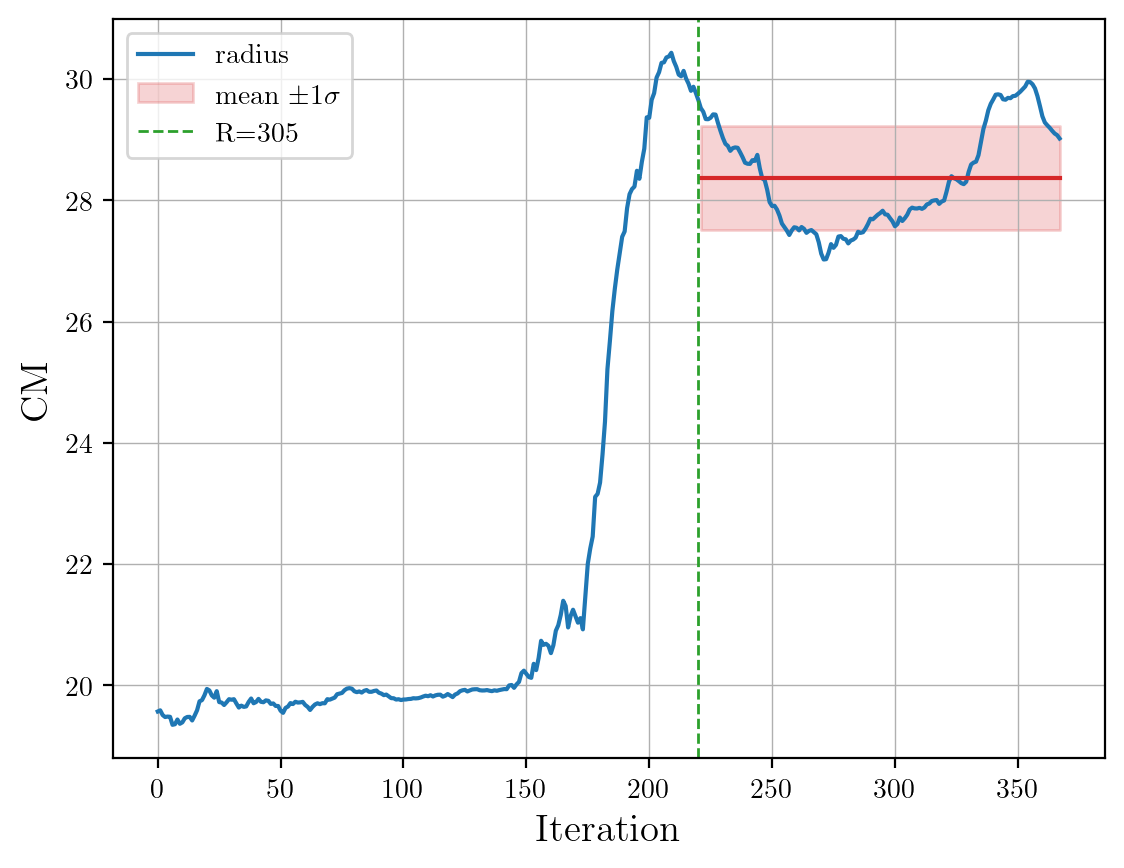

CM_x = -7.59, CM_y = 27.33 using the "shrinking sphere method" 


In [16]:
idx_t = [0,500]
rlim = 10
last_counts=220
snaps=len(idx_t)
col=plt.colormaps['plasma'](np.linspace(0,1,snaps))

r = {}
theta = {}
theta_punto = {}
v={}

r[0] = (x[::,idx_t[0]]**2 +y[::,idx_t[0]]**2)**0.5
v[0] = (vx[::,idx_t[0]]**2 +vy[::,idx_t[0]]**2)**0.5
theta_punto[0] = (vy[::,idx_t[0]]*x[::,idx_t[0]] - vx[::,idx_t[0]]*y[::,idx_t[0]])/r[0]**2

for j in [1]:
    cm_x,cm_y = shrinking_sphere(x[::,idx_t[j]],y[::,idx_t[j]],M,N,last_counts=last_counts, rlim=rlim)

    x_new = x[::,idx_t[j]] - cm_x
    y_new = y[::,idx_t[j]] - cm_y
    r[j] = (x_new**2 + y_new**2)**(0.5)
    theta[j] = np.arccos(x_new/r[j])
    theta[j][y_new<0] = -theta[j][y_new<0]
    theta_punto[j] = (vy[::,j]*x_new - vx[::,j]*y_new)/r[j]**2
    v[j] = (vx[::,idx_t[j]]**2+vy[::,idx_t[j]]**2)**(1/2)

print('CM_x = %.2f, CM_y = %.2f using the "shrinking sphere method" '%(cm_x,cm_y))

In [17]:
idx_t = [0,500]
rlim = 10
last_counts=220
snaps=len(idx_t)
col=plt.colormaps['plasma'](np.linspace(0,1,snaps))

r2 = {}
theta2 = {}
theta_punto2 = {}
v2 = {}

for j in range(snaps):

    maximum=np.argmin(phi[::,idx_t[j]])
    cm_x2=x[maximum,idx_t[j]]
    cm_y2=y[maximum,idx_t[j]]
    x_new = x[::,idx_t[j]] - cm_x2
    y_new = y[::,idx_t[j]] - cm_y2
    r2[j] = (x_new**2 + y_new**2)**(0.5)
    theta2[j] = np.arccos(x_new/r2[j])
    theta2[j][y_new<0] = -theta2[j][y_new<0]
    theta_punto2[j] = (vy[::,j]*x_new - vx[::,j]*y_new)/r2[j]**2
    v2[j] = (vx[::,idx_t[j]]**2+vy[::,idx_t[j]]**2)**(1/2)

print('CM_x = %.2f, CM_y = %.2f using the method with the potential '%(cm_x2,cm_y2))

CM_x = -9.74, CM_y = 26.23 using the method with the potential 


/tmp/ipykernel_11665/2166034605.py:20: RuntimeWarning: invalid value encountered in true_divide
  theta2[j] = np.arccos(x_new/r2[j])
/tmp/ipykernel_11665/2166034605.py:22: RuntimeWarning: invalid value encountered in true_divide
  theta_punto2[j] = (vy[::,j]*x_new - vx[::,j]*y_new)/r2[j]**2


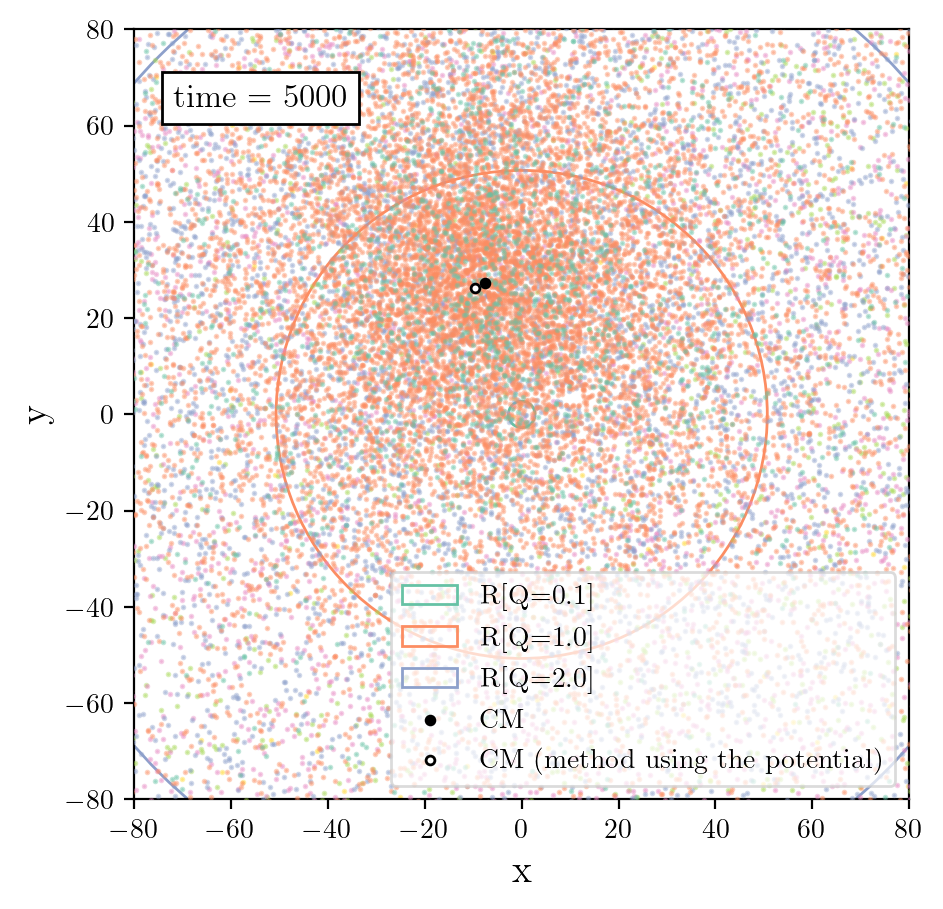

In [18]:
N_shell=[3000,20000,20000,20000,20000, 20000, 30000] #[1e-1,1,2,3,5,10]
idx_R = [0,3000,23000,43000,63000,83000,1030000, 133000]
Q_val = [1e-1,1,2,3,5,10]
R_shell = np.array([R_Q(q) for q in Q_val])
R_shell = np.insert(R_shell,0,0)
R_shell = np.append(R_shell, 1e5)

col=plt.colormaps['Set2'](np.linspace(0,1,8))
col=np.delete(col,6,axis=0)

fig = plt.figure(figsize = (5,5))
idx_t = [500]
snaps=len(idx_t)
zorder=[7,6,5,4,3,2,1]

for i in range(snaps):
    ax = fig.add_subplot(1,1,i+1)
    
    for l in range(len(idx_R[:-1])):
        ax.scatter(x[idx_R[l]:idx_R[l+1],idx_t[i]], y[idx_R[l]:idx_R[l+1],idx_t[i]], color=col[l], s=1, alpha=0.4, zorder=zorder[l])
    for q,c in zip(Q_val[:3],col[:3]):
        circle_Q = plt.Circle((0, 0, 0), R_Q(q), color=c, fill=False, label='R[Q=%.1f]'%q)
        ax.add_patch(circle_Q)
    ax.scatter(cm_x,cm_y, color='k', s=10, label='CM', zorder=10)
    ax.scatter(cm_x2,cm_y2, color='k', fc = 'white', ec='k',s=10, label='CM (method using the potential)',zorder=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(-80,80)
    ax.set_ylim(-80,80)
    ax.text(0.05, 0.9, 'time = %i'%time[idx_t[i]], transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white')).set_zorder(10)
    ax.grid()
    ax.legend(framealpha=0.7, loc='lower right').set_zorder(10)
#plt.savefig('CM2.jpg',dpi=300)
plt.show()

In [24]:
mask={}
for j in range(snaps):
    mask[j]=r[j]<305
mask2={}
for j in range(snaps):
    mask2[j]=r2[j]<305

In [25]:
idx_t = [0,500]
snaps=len(idx_t)

shell_Sigma={}
shell_k={}
shell_sigma={}
shell_Q={}

shell_Sigma2={}
shell_k2={}
shell_sigma2={}
shell_Q2={}

for j in range(snaps):
    R = r[j][mask[j]]
    V = v[j][mask[j]]
    Mass = M[mask[j]]
    Theta_punto = theta_punto[j][mask[j]]
    Theta_punto_sort = Theta_punto[np.argsort(R)]
    R_sorted = R[np.argsort(R)]
    shell_r  = np.geomspace(R_sorted[2],a,30)[1::3]
    shell_r = np.append(shell_r, np.geomspace(a+1,max(R),31))
    shell_r_med = (shell_r[:-1] + shell_r[1:]) / 2

    shell_A = np.array([np.pi*shell_r[i+1]**2 - np.pi*shell_r[i]**2 for i in range(len(shell_r)-1)])
    shell_M = np.array([np.sum(Mass[np.logical_and(R>shell_r[i],R<shell_r[i+1])]) for i in range(len(shell_r)-1)])
    shell_Sigma[j] = shell_M/shell_A
    
    Theta_punto_ext = np.array([Theta_punto_sort[find_nearest(R_sorted,shell_r[i])] for i in range(len(shell_r)-1)])
    Theta_punto_int = np.array([Theta_punto_sort[find_nearest(R_sorted,shell_r[i])] for i in range(len(shell_r)-1)])
    shell_der = np.array([(Theta_punto_ext[i] - Theta_punto_int[i]) / (shell_r[i+1]-shell_r[i]) for i in range(len(shell_r)-1)])
    shell_k[j] = np.array([(np.mean(R[np.logical_and(R>shell_r[i],R<shell_r[i+1])]) * shell_der[i] + 4*np.mean(Theta_punto[np.logical_and(R>shell_r[i],R<shell_r[i+1])]**2))**(1/2)  for i in range(len(shell_r)-1)])

    shell_sigma[j] = np.array([np.std(V[np.logical_and(R>shell_r[i],R<shell_r[i+1])]) for i in range(len(shell_r)-1)])

    shell_Q[j] = shell_k[j]*shell_sigma[j] / (3.36*shell_Sigma[j])

for j in range(snaps):
    R = r2[j][mask2[j]]
    V = v2[j][mask2[j]]
    Mass = M[mask2[j]]
    Theta_punto = theta_punto2[j][mask2[j]]
    Theta_punto_sort = Theta_punto[np.argsort(R)]
    R_sorted = R[np.argsort(R)]
    shell_r  = np.geomspace(R_sorted[2],a,30)[1::3]
    shell_r = np.append(shell_r, np.geomspace(a+1,max(R),31))
    shell_r_med = (shell_r[:-1] + shell_r[1:]) / 2

    shell_A = np.array([np.pi*shell_r[i+1]**2 - np.pi*shell_r[i]**2 for i in range(len(shell_r)-1)])
    shell_M = np.array([np.sum(Mass[np.logical_and(R>shell_r[i],R<shell_r[i+1])]) for i in range(len(shell_r)-1)])
    shell_Sigma2[j] = shell_M/shell_A
    
    Theta_punto_ext = np.array([Theta_punto_sort[find_nearest(R_sorted,shell_r[i])] for i in range(len(shell_r)-1)])
    Theta_punto_int = np.array([Theta_punto_sort[find_nearest(R_sorted,shell_r[i])] for i in range(len(shell_r)-1)])
    shell_der = np.array([(Theta_punto_ext[i] - Theta_punto_int[i]) / (shell_r[i+1]-shell_r[i]) for i in range(len(shell_r)-1)])
    shell_k2[j] = np.array([(np.mean(R[np.logical_and(R>shell_r[i],R<shell_r[i+1])]) * shell_der[i] + 4*np.mean(Theta_punto[np.logical_and(R>shell_r[i],R<shell_r[i+1])]**2))**(1/2)  for i in range(len(shell_r)-1)])

    shell_sigma2[j] = np.array([np.std(V[np.logical_and(R>shell_r[i],R<shell_r[i+1])]) for i in range(len(shell_r)-1)])

    shell_Q2[j] = shell_k2[j]*shell_sigma2[j] / (3.36*shell_Sigma2[j])


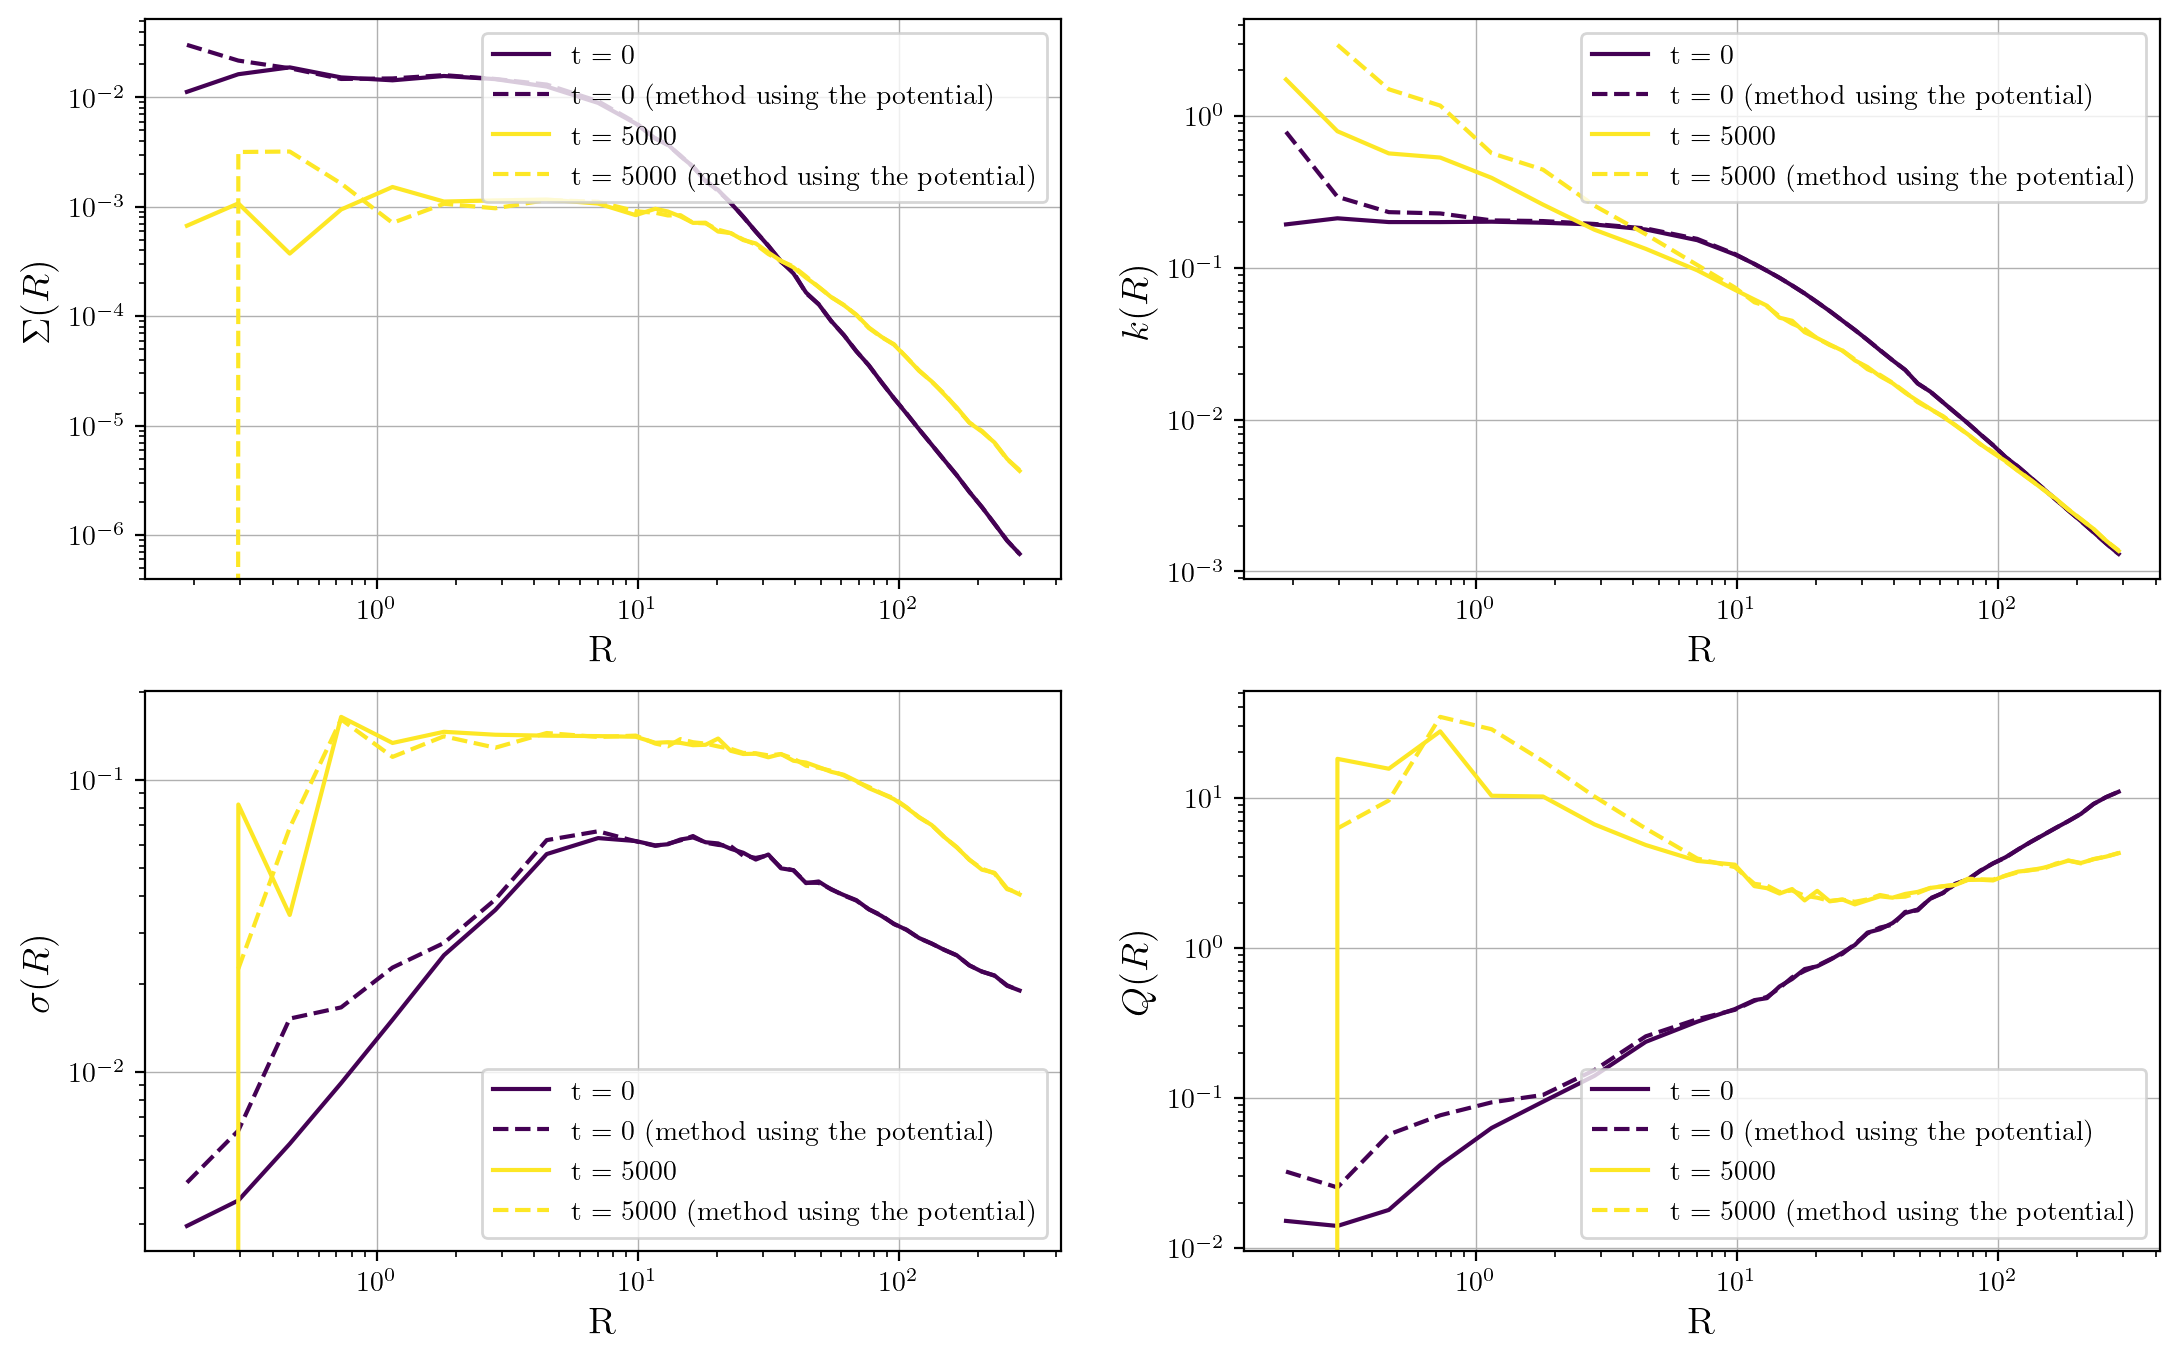

In [26]:
fig = plt.figure(figsize=(13,8))
col=plt.colormaps['viridis'](np.linspace(0,1,snaps))

ax = fig.add_subplot(221)
for j in range(snaps):
    ax.loglog(shell_r_med,shell_Sigma[j], c=col[j], label='t = %i'%time[idx_t[j]])
    ax.loglog(shell_r_med,shell_Sigma2[j], c=col[j], ls='--', label='t = %i (method using the potential)'%time[idx_t[j]])

    ax.set_ylabel('$\Sigma(R)$')
    ax.set_xlabel('R')
    ax.legend(loc='upper right')

ax = fig.add_subplot(222)
for j in range(snaps):
    ax.loglog(shell_r_med,shell_k[j], c=col[j], label='t = %i'%time[idx_t[j]])
    ax.loglog(shell_r_med,shell_k2[j], c=col[j], ls='--', label='t = %i (method using the potential)'%time[idx_t[j]])
    ax.set_ylabel('$k(R)$')
    ax.set_xlabel('R')
    ax.legend(loc='upper right')

ax = fig.add_subplot(223)
for j in range(snaps):
    ax.loglog(shell_r_med,shell_sigma[j], c=col[j], label='t = %i'%time[idx_t[j]])
    ax.loglog(shell_r_med,shell_sigma2[j], c=col[j], ls='--', label='t = %i (method using the potential)'%time[idx_t[j]])

    ax.set_ylabel('$\sigma(R)$')
    ax.set_xlabel('R')
    ax.legend(loc='lower right')

ax = fig.add_subplot(224)
for j in range(snaps):
    ax.loglog(shell_r_med,shell_Q[j], c=col[j], label='t = %i'%time[idx_t[j]])
    ax.loglog(shell_r_med,shell_Q2[j], c=col[j], ls='--', label='t = %i (method using the potential)'%time[idx_t[j]])

    ax.set_ylabel('$Q(R)$')
    ax.set_xlabel('R')
    ax.legend(loc='lower right')
plt.savefig('profile_evolution_int_2.png',dpi=300)
plt.show()